In [1]:
%pylab inline
import numpy as np
import torch

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import dataloader

from torchvision import transforms
from torchvision.datasets import MNIST

from sklearn.metrics import accuracy_score

from graphviz import Digraph

Populating the interactive namespace from numpy and matplotlib


## Configuration

In [2]:
BATCH_SIZE = 32

## Data (MNIST)

In [3]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
    
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE ,num_workers=1, pin_memory=True)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

## Model Discriminator

### Discriminator

* $ x_i \sim P_{\rm data} $ (즉 true data distribution) 에서 왔다면 1
* $ x_i = G(z) $ 이때 $ z \sim p_{\rm generator} $ (generators' distribution)에서 왔다면 0

즉 Discriminator는 "이 사진이 진짜냐? (가짜가 아니고)" 라고 질문하는 것

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(784, 548)
        self.fc2 = nn.Linear(548, 252)
        self.fc3 = nn.Linear(252, 1)
        
        self.bc1 = nn.BatchNorm1d(548)
        self.bc2 = nn.BatchNorm1d(252)
                
    def forward(self, x):
        x = x.view((-1, 784))
        h = self.fc1(x)
        h = self.bc1(h)
        h = F.relu(h)
#         h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc2(h)
        h = self.bc2(h)
        h = F.relu(h)
#         h = F.dropout(h, p=0.2, training=self.training)
        
        h = self.fc3(h)
        out = F.sigmoid(h)
        return out

D = Discriminator()
print(D.cuda()) # CUDA!
d_optimizer = optim.Adam(D.parameters(), lr=0.001)

Discriminator (
  (fc1): Linear (784 -> 548)
  (fc2): Linear (548 -> 252)
  (fc3): Linear (252 -> 1)
  (bc1): BatchNorm1d(548, eps=1e-05, momentum=0.1, affine=True)
  (bc2): BatchNorm1d(252, eps=1e-05, momentum=0.1, affine=True)
)


### Generator

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(100, 196)
        self.fc2 = nn.Linear(196, 289)
        self.fc3 = nn.Linear(289, 400)
        self.fc4 = nn.Linear(400, 512)
        self.fc5 = nn.Linear(512, 625)
        self.fc6 = nn.Linear(625, 784)
        
        self.bc1 = nn.BatchNorm1d(196)
        self.bc2 = nn.BatchNorm1d(289)
        self.bc3 = nn.BatchNorm1d(400)
        self.bc4 = nn.BatchNorm1d(512)
        self.bc5 = nn.BatchNorm1d(625)
    
    def forward(self, x):
        h = self.fc1(x)
        h = self.bc1(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc2(h)
        h = self.bc2(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc3(h)
        h = self.bc3(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc4(h)
        h = self.bc4(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc5(h)
        h = self.bc5(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc6(h)
        out = F.sigmoid(h)
        return out

G = Generator()
print(G.cuda())
g_optimizer = optim.Adam(G.parameters(), lr=0.001)

Generator (
  (fc1): Linear (100 -> 196)
  (fc2): Linear (196 -> 289)
  (fc3): Linear (289 -> 400)
  (fc4): Linear (400 -> 512)
  (fc5): Linear (512 -> 625)
  (fc6): Linear (625 -> 784)
  (bc1): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True)
  (bc2): BatchNorm1d(289, eps=1e-05, momentum=0.1, affine=True)
  (bc3): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True)
  (bc4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (bc5): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True)
)


## Train

* $ 1 $ : real images
* $ 0 $ : fake images

In [6]:
N_EPOCH = 100

real_y = Variable(torch.ones((BATCH_SIZE, 1)).cuda())
fake_y = Variable(torch.zeros((BATCH_SIZE, 1)).cuda())
loss_f = nn.BCELoss()

d_real_losses = list()
d_fake_losses = list()
d_losses = list()
g_losses = list()
divergences = list()

In [18]:
# Train Discriminator with Generator not being trained
# 먼저 Discriminator를 학습시킵니다.
# 이때 real image와 fake이미지 두개의 데이터를 사용하여 학습합니다. 
# Discriminator를 학습시킬때는 Generator는 학습시키면 안됩니다.
params = list(G.parameters())
d_params = list(D.parameters())

for epoch in range(N_EPOCH):
    for step, (real_images, _) in enumerate(train_loader):
        # Samples
        real_images = Variable(real_images.cuda())
        z = Variable(torch.randn((BATCH_SIZE, 100)).cuda())
                
        ###############################################
        # Train D (But do not train G)
        ###############################################
        # Init D
        d_optimizer.zero_grad()
        
        # Calculate the loss with real images
        y_real_pred = D(real_images)
        d_real_loss = loss_f(y_real_pred, real_y)
#         d_real_loss.backward()
#         d_optimizer.step()
        
        # Calculate the loss with fake images
        fake_distributions = Variable(torch.randn((BATCH_SIZE, 100)).cuda())
        fake_images = G(fake_distributions).detach()
        y_fake_pred = D(fake_images)
        d_fake_loss = loss_f(y_fake_pred, fake_y)
#         d_fake_loss.backward()
#         d_optimizer.step()
        
        # Update D with G not being updated        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        ###############################################
        # Train G with fake images but do not train G
        ###############################################
        g_optimizer.zero_grad()
        
        fake_distributions = Variable(torch.randn((BATCH_SIZE, 100)).cuda())
        fake_images = G(fake_distributions)
        y_pred = D(fake_images)
        g_loss = loss_f(y_pred, real_y)
        g_loss.backward()
        g_optimizer.step()
        
        ###############################################
        # Visualization
        ###############################################
        d_real_losses.append(d_real_loss.data[0])
        d_fake_losses.append(d_fake_loss.data[0])
        d_losses.append(d_loss.data[0])
        g_losses.append(g_loss.data.cpu().numpy()[0])
    
        divergences.append(torch.mean(y_real_pred/(y_real_pred+y_fake_pred)).data[0])
        
        if step % 50 == 0:
            print(f'\r[{epoch+1}/{N_EPOCH}]',
                  # '{:.4}'.format(torch.mean(params[0]).data[0]),
#                   'divergence: {:<8.4}'.format(np.mean(divergences[-100:])),
                  'D: {:<8.4}'.format(np.mean(d_fake_losses[-100:])), 
                  'D_real: {:<8.4}'.format(np.mean(d_real_losses[-100:])),
                  'D_fake: {:<8.4}'.format(np.mean(d_fake_losses[-100:])), 
                  'G:{:<8.4}'.format(np.mean(g_losses[-100:])), end='')
    print()

[1/100] D: 0.07444  D_real: 0.07872  D_fake: 0.07444  G:6.378   
[2/100] D: 0.07674  D_real: 0.06374  D_fake: 0.07674  G:6.196   
[3/100] D: 0.06219  D_real: 0.07933  D_fake: 0.06219  G:6.803   
[4/100] D: 0.0729   D_real: 0.07354  D_fake: 0.0729   G:6.342   
[5/100] D: 0.08037  D_real: 0.08329  D_fake: 0.08037  G:6.3     
[6/100] D: 0.06493  D_real: 0.06522  D_fake: 0.06493  G:6.518   
[7/100] D: 0.06645  D_real: 0.07202  D_fake: 0.06645  G:6.751   
[8/100] D: 0.1011   D_real: 0.1135   D_fake: 0.1011   G:6.619   
[9/100] D: 0.05791  D_real: 0.06298  D_fake: 0.05791  G:6.232   
[10/100] D: 0.08533  D_real: 0.07227  D_fake: 0.08533  G:6.521   
[11/100] D: 0.06457  D_real: 0.07412  D_fake: 0.06457  G:6.282   
[12/100] D: 0.08064  D_real: 0.1048   D_fake: 0.08064  G:7.251   
[13/100] D: 0.09248  D_real: 0.09496  D_fake: 0.09248  G:6.548   
[14/100] D: 0.07116  D_real: 0.06924  D_fake: 0.07116  G:6.04    
[15/100] D: 0.06135  D_real: 0.06802  D_fake: 0.06135  G:6.732   
[16/100] D: 0.05809

## Loss Visualization

In [8]:
def smooth(x,window_len=100,window='hanning'):
    x = np.array(x)
    
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=numpy.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y

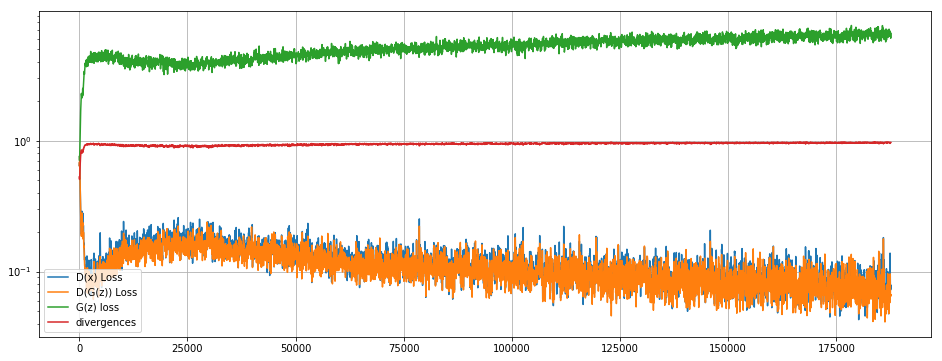

In [9]:
figsize(16, 6)
plot(smooth(d_real_losses), label='D(x) Loss')
plot(smooth(d_fake_losses), label='D(G(z)) Loss')
plot(smooth(g_losses), label='G(z) loss')
plot(smooth(divergences), label='divergences')
yscale('log')
grid()
legend()

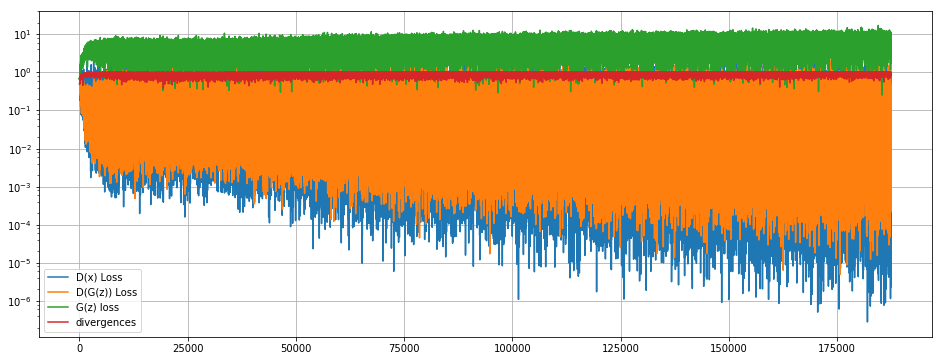

In [10]:
plot(d_real_losses, label='D(x) Loss')
plot(d_fake_losses, label='D(G(z)) Loss')
plot(g_losses, label='G(z) loss')
plot(divergences, label='divergences')

yscale('log')
grid()
legend()

# Evaluate

## Evaluate Generator

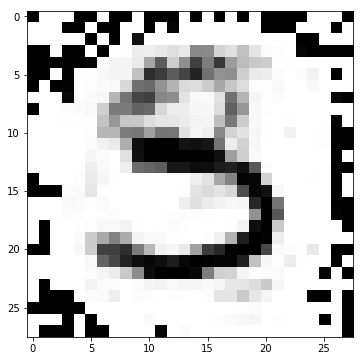

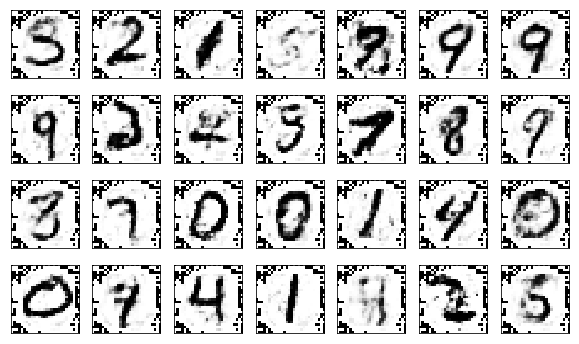

In [21]:
fake_distributions = Variable(torch.randn((BATCH_SIZE, 100)).cuda())
images = G(fake_distributions).view((-1, 28, 28)).data.cpu().numpy()

images[0]
imshow(images[0], cmap=cm.gray_r)

figsize(10, 6)
fig, subplots = pylab.subplots(4, 7) # subplots(y축, x축 갯수)

idx = 0
for _subs in subplots:
    for subplot in _subs:
        d = images[idx]
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)
        subplot.imshow(d, cmap=cm.gray_r)
        idx += 1


## Evaluate Discriminator

In [17]:
n_test = test_loader.dataset.test_data.size()[0]
y_test_real_labels = np.ones((n_test, 1))
y_test_fake_labels = np.zeros((n_test, 1))

# Predict Real Images
test_data = Variable(test_loader.dataset.test_data.cuda().type_as(torch.cuda.FloatTensor()))
y_test_real_pred = D(test_data)


# Predict Fake Images
fake_distributions = Variable(torch.randn((n_test, 100)).cuda())
fake_images = G(fake_distributions).detach()
y_test_fake_pred = D(fake_images)

# Evaluate
y_test_real_pred = torch.round(y_test_real_pred).data.cpu().numpy()
y_test_fake_pred = torch.round(y_test_fake_pred).data.cpu().numpy()

print('Discriminator Real Image Accuracy:', accuracy_score(y_test_real_labels, y_test_real_pred))
print('Discriminator Fake Image Accuracy:', accuracy_score(y_test_fake_labels, y_test_fake_pred))

Discriminator Real Image Accuracy: 0.9996
Discriminator Fake Image Accuracy: 0.9991
